<a href="https://colab.research.google.com/github/amun83/Koscom-FinancialDataCamp/blob/master/FD102_Forecasting_Natural_Gas_ETN_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q fbprophet
!pip install -q pandas_datareader
!pip install -q finance-datareader
!pip install -q html5lib
!pip install -q lxml
!pip install -q gspread

In [0]:
# utilities
import datetime
import re
from IPython.display import display

# web scraping
import requests
import urllib.parse
from bs4 import BeautifulSoup
import pandas_datareader as pdr
import FinanceDataReader as fdr

# Math/Stat
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly

# visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

## Summary

### ETF/ETN@KRX
* 신한 천연가스 선물 ETN(H)
* 신한 레버리지 천연가스 선물 ETN(H)
* 신한 인버스 천연가스 선물 ETN(H)
* 신한 인버스 2X 천연가스 선물 ETN(H)
* 삼성 레버리지 천연가스 선물 ETN
* 삼성 인버스 2X 천연가스 선물 ETN

### Data
* Henry Hub Spot
* NYMEX Futures
* EIA 재고량, 생산량
* NOAA Arctic Oscillation Index
* Bloomberg 미국 기온
* CHECK Dow Jones Commodity Index Natural Gas TR
* CHECK US Dollar Index
* CHECK Crude Oil WTI Futures
* CFTC Non-Commercial Net Positions

### Data Sources
* https://www.investing.com/commodities/natural-gas
* https://www.eia.gov/naturalgas/data.php
* http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao_index.html
* https://www.barchart.com/futures/quotes/NG*0/technical-chart?plot=BAR&volume=0&data=MN&density=X&pricesOn=1&asPctChange=0&logscale=0&indicators=COTLC;COTDLC&sym=NGZ18&grid=1&height=375&studyheight=100

### Methods
* Correlation Matrix
* Facebook Prophet (ARIMA)

## 데이터 준비 I

In [67]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [36]:
# Dow Jones Commodity Index Natural Gas TR
with open("/gdrive/My Drive/Natural Gas Data/DJCI.csv", "r") as f:
  df_DJCI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_DJCI.head(3), df_DJCI.tail(3)]))

,Dow Jones Commodity Index Natural Gas TR,Dow Jones Commodity Index Natural Gas ER,Dow Jones Commodity Index Natural Gas
Effective date,,,
2018-11-16,0.85,0.60,233.33
2018-11-15,0.80,0.56,219.85
2018-11-14,0.97,0.68,266.34
2008-11-04,21.64,15.70,392.55
2008-11-03,20.50,14.87,371.83
2008-10-31,20.33,14.75,368.84


In [37]:
# Henry Hub Natural Gas Spot
with open("/gdrive/My Drive/Natural Gas Data/NG_Spot.csv", "r") as f:
  df_Spot = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Spot.head(3), df_Spot.tail(3)]))
  

,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
Date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
2018-11-09,3.74
2018-11-12,3.96
2018-11-13,4.10


In [38]:
# NYMEX Natural Gas Futures
with open("/gdrive/My Drive/Natural Gas Data/NG_Futures.csv", "r") as f:
  df_Futures = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Futures.head(3), df_Futures.tail(3)]))


,Natural Gas Futures Contract 1 (Dollars per Million Btu),Natural Gas Futures Contract 2 (Dollars per Million Btu),Natural Gas Futures Contract 3 (Dollars per Million Btu),Natural Gas Futures Contract 4 (Dollars per Million Btu)
Date,,,,
1993-12-20,NaN,NaN,NaN,1.894
1993-12-21,NaN,NaN,NaN,1.830
1993-12-22,NaN,NaN,NaN,1.859
2018-11-12,3.788,3.800,3.660,3.293
2018-11-13,4.101,4.147,4.019,3.712
2018-11-14,4.837,4.898,4.770,4.472


In [39]:
# EIA Weekly Natural Gas Storage Report
with open("/gdrive/My Drive/Natural Gas Data/NG_Storage.csv", "r") as f:
  df_Storage = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Storage.head(3), df_Storage.tail(3)]))

,Source,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
Week ending,,,,,,,,,
2010-01-01,Derived EIA Weekly Estimates,769,900,195,268,985,159,826,3117
2010-01-08,Derived EIA Weekly Estimates,703,820,185,257,886,123,763,2850
2010-01-15,Derived EIA Weekly Estimates,642,750,176,246,793,91,702,2607
2018-10-26,EIA-912,826,956,180,262,919,234,686,3143
2018-11-02,EIA-912,831,980,182,265,949,253,696,3208
2018-11-09,EIA-912,835,991,181,266,974,272,702,3247


In [41]:
# EIA Monthly Gross Withdrawals and Production
with open("/gdrive/My Drive/Natural Gas Data/Production.csv", "r") as f:
  df_Production = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Production.head(3), df_Production.tail(3)]))

,U.S. Natural Gas Gross Withdrawals (MMcf),U.S. Natural Gas Gross Withdrawals from Gas Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Oil Wells (MMcf),U.S. Natural Gas Gross Withdrawals from Shale Gas (Million Cubic Feet),U.S. Natural Gas Gross Withdrawals from Coalbed Wells (MMcf),U.S. Natural Gas Repressuring (MMcf),U.S. Natural Gas Vented and Flared (MMcf),U.S. Nonhydrocarbon Gases Removed from Natural Gas (MMcf),U.S. Natural Gas Marketed Production (MMcf),U.S. Natural Gas Plant Liquids Production (Million Cubic Feet),U.S. Dry Natural Gas Production (MMcf),Unnamed: 12
Date,,,,,,,,,,,,
1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948000,79000,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962000,79000,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1907000,77000,NaN,NaN
2018-06-01,2954943.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2641008,187394,2453614.0,NaN
2018-07-01,3106695.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2782326,197213,2585113.0,NaN
2018-08-01,3178843.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2843746,203516,2640230.0,NaN


In [42]:
# US Temperature
with open("/gdrive/My Drive/Natural Gas Data/Temperature.csv", "r") as f:
  df_Temperature = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_Temperature.head(3), df_Temperature.tail(3)]))

,Avg,Min,Max
Date,,,
2018-11-19,15.82,11.43,20.20
2018-11-18,15.48,11.03,19.93
2018-11-17,15.91,11.38,20.44
2013-11-29,14.48,9.06,19.90
2013-11-28,13.96,8.75,19.17
2013-11-27,14.47,9.53,19.40


In [43]:
# NOAA Arctic Oscillation Index
with open("/gdrive/My Drive/Natural Gas Data/AO_Index.csv", "r") as f:
  df_AOI = pd.read_csv(f, header = None, index_col = 0, parse_dates = [[0, 1, 2]])
  display(pd.concat([df_AOI.head(3), df_AOI.tail(3)])) 

,3
0_1_2,
1979-01-01,-1.556
1979-01-02,-0.888
1979-01-03,0.255
2018-10-29,0.508
2018-10-30,0.754
2018-10-31,0.776


In [44]:
# Crude Oil WTI Futures
with open("/gdrive/My Drive/Natural Gas Data/WTI_Futures.csv", "r") as f:
  df_WTI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_WTI.head(3), df_WTI.tail(3)]))  

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,56.98,57.31,57.55,56.83,-,-0.56%
2018-11-18,57.30,57.00,57.36,56.93,-,1.49%
2018-11-16,56.46,56.58,57.96,55.89,159.00K,0.00%
1990-01-04,23.41,23.90,23.92,22.83,53.07K,-1.14%
1990-01-03,23.68,23.19,23.80,23.00,50.06K,3.45%
1990-01-02,22.89,21.81,22.92,21.79,45.18K,4.90%


In [45]:
# US Dollar Index
with open("/gdrive/My Drive/Natural Gas Data/Dollar_Index.csv", "r") as f:
  df_DI = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_DI.head(3), df_DI.tail(3)]))

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-11-19,96.36,96.45,96.57,96.32,-,-0.07%
2018-11-18,96.43,96.43,96.45,96.38,-,-0.04%
2018-11-16,96.47,97.05,97.06,96.40,-,-0.47%
1990-01-03,94.42,94.15,94.52,94.08,-,0.14%
1990-01-02,94.29,93.13,94.31,93.08,-,1.16%
1990-01-01,93.21,93.19,93.31,93.08,-,0.00%


## 데이터 준비 II : CFTC  Non-Commercial  Net Positions
* https://colab.research.google.com/drive/1YvdML1V_0VCqwkPCny528AIPjCZUbIYw

In [72]:
# CFTC Weekly Non-Commercial Net Positions
with open("/gdrive/My Drive/Natural Gas Data/CFTC.csv", "r") as f:
  df_CFTC = pd.read_csv(f, index_col = 0, parse_dates = True)
  display(pd.concat([df_CFTC.head(3), df_CFTC.tail(3)]))
  # COTDLC (M)

,COTDLC (M),COTDLC (O),COTDLC (P),COTDLC (S),COTLC (C),COTLC (L),COTLC (S),Interest,Volume,close,high,low,open,symbol
date,,,,,,,,,,,,,,
2018-11-21,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,NaN,5,5,5,5,NGZ18
2018-11-20,279113,-256767,-50347,-9794,-60141,22346,37795,NaN,697315.0,5,5,4,5,NGZ18
2018-11-19,279113,-256767,-50347,-9794,-60141,22346,37795,1381403.0,805724.0,5,5,4,5,NGZ18
2012-11-05,36281,-85285,-40316,48164,7848,-49004,41156,1175941.0,217603.0,4,4,4,4,NGZ12
2012-11-02,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,290111.0,4,4,4,4,NGZ12
2012-11-01,36281,-85285,-40316,48164,7848,-49004,41156,1185202.0,272918.0,4,4,4,4,NGZ12


## 데이터 통합

In [114]:
M = pd.concat([ df_DJCI['Dow Jones Commodity Index Natural Gas TR'],
                df_Spot,
                df_Futures['Natural Gas Futures Contract 1 (Dollars per Million Btu)'],
                df_Storage['Total Lower 48'],
                df_Production['U.S. Natural Gas Gross Withdrawals (MMcf)'],
                df_Temperature['Avg'],
                df_AOI,
                df_WTI['Price'],
                df_DI['Price'],
                df_CFTC['COTDLC (M)'] ], axis = 1)

M.columns = ['DJCI', 'Spot', 'Futures', 'Storage', 'Production', 'Temperature', 'AOI', 'WTI', 'DI', 'CFTC']

M.tail(10)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
2018-11-12,0.76,3.96,3.788,NaN,NaN,16.20,NaN,59.93,97.54,245106.0
2018-11-13,0.82,4.10,4.101,NaN,NaN,15.82,NaN,55.69,97.30,279113.0
2018-11-14,0.97,NaN,4.837,NaN,NaN,15.25,NaN,56.25,96.80,279113.0
2018-11-15,0.80,NaN,NaN,NaN,NaN,15.45,NaN,56.46,96.93,279113.0
2018-11-16,0.85,NaN,NaN,NaN,NaN,15.79,NaN,56.46,96.47,279113.0
2018-11-17,NaN,NaN,NaN,NaN,NaN,15.91,NaN,NaN,NaN,NaN
2018-11-18,NaN,NaN,NaN,NaN,NaN,15.48,NaN,57.30,96.43,NaN
2018-11-19,NaN,NaN,NaN,NaN,NaN,15.82,NaN,56.98,96.36,279113.0
2018-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279113.0
2018-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279113.0


In [115]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14642 entries, 1973-01-01 to 2018-11-21
Data columns (total 10 columns):
DJCI           2532 non-null float64
Spot           5500 non-null float64
Futures        6230 non-null float64
Storage        463 non-null float64
Production     464 non-null float64
Temperature    1819 non-null float64
AOI            14548 non-null float64
WTI            7312 non-null float64
DI             7486 non-null float64
CFTC           1526 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [116]:
M.isnull().sum()

DJCI           12110
Spot            9142
Futures         8412
Storage        14179
Production     14178
Temperature    12823
AOI               94
WTI             7330
DI              7156
CFTC           13116
dtype: int64

In [0]:
M['DJCI'       ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Spot'       ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Futures'    ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Storage'    ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['Temperature'].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['AOI'        ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['WTI'        ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['DI'         ].interpolate(method = 'time'   , limit_direction='forward', inplace = True)
M['CFTC'       ].interpolate(method = 'nearest', limit_direction='forward', inplace = True)



In [118]:
M['Production'] = M['Production'].apply(lambda x : x / 30)
M['Production'].fillna(method = 'ffill', inplace = True)

M.tail(10)

,DJCI,Spot,Futures,Storage,Production,Temperature,AOI,WTI,DI,CFTC
2018-11-12,0.76,3.96,3.788,3247.0,105961.433333,16.20,0.776,59.93,97.54,245106.0
2018-11-13,0.82,4.10,4.101,3247.0,105961.433333,15.82,0.776,55.69,97.30,279113.0
2018-11-14,0.97,4.10,4.837,3247.0,105961.433333,15.25,0.776,56.25,96.80,279113.0
2018-11-15,0.80,4.10,4.837,3247.0,105961.433333,15.45,0.776,56.46,96.93,279113.0
2018-11-16,0.85,4.10,4.837,3247.0,105961.433333,15.79,0.776,56.46,96.47,279113.0
2018-11-17,0.85,4.10,4.837,3247.0,105961.433333,15.91,0.776,56.88,96.45,279113.0
2018-11-18,0.85,4.10,4.837,3247.0,105961.433333,15.48,0.776,57.30,96.43,279113.0
2018-11-19,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-20,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0
2018-11-21,0.85,4.10,4.837,3247.0,105961.433333,15.82,0.776,56.98,96.36,279113.0


## 데이터 개괄

In [0]:
M.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14564 entries, 1979-01-01 to 2018-11-19
Data columns (total 7 columns):
DJCI       3668 non-null float64
Spot       7983 non-null float64
Futures    9073 non-null float64
Storage    3241 non-null float64
AOI        14564 non-null float64
WTI        10545 non-null float64
DI         10546 non-null float64
dtypes: float64(7)
memory usage: 910.2 KB


In [0]:
M.describe()

,DJCI,Spot,Futures,Storage,AOI,WTI,DI
count,3668.000000,7983.000000,9073.000000,3241.000000,14564.000000,10545.000000,10546.000000
mean,3.069221,4.350469,4.130124,2750.979416,0.065297,47.456862,90.731160
std,3.468799,2.240548,2.260163,762.628439,1.374540,29.801846,10.223730
min,0.510000,1.050000,1.323000,824.000000,-5.125000,10.720000,71.330000
25%,0.793333,2.771667,2.509000,2214.142857,-0.807000,21.010000,82.664167
50%,1.853333,3.730000,3.459000,2810.000000,0.139000,36.960000,89.468333
75%,4.020000,5.482000,5.170000,3355.142857,1.021000,69.310000,96.318333
max,21.730000,18.480000,15.378000,4047.000000,4.635000,145.290000,120.900000


In [0]:
M.isnull().sum()

DJCI       10896
Spot        6581
Futures     5491
Storage    11323
AOI            0
WTI         4019
DI          4018
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


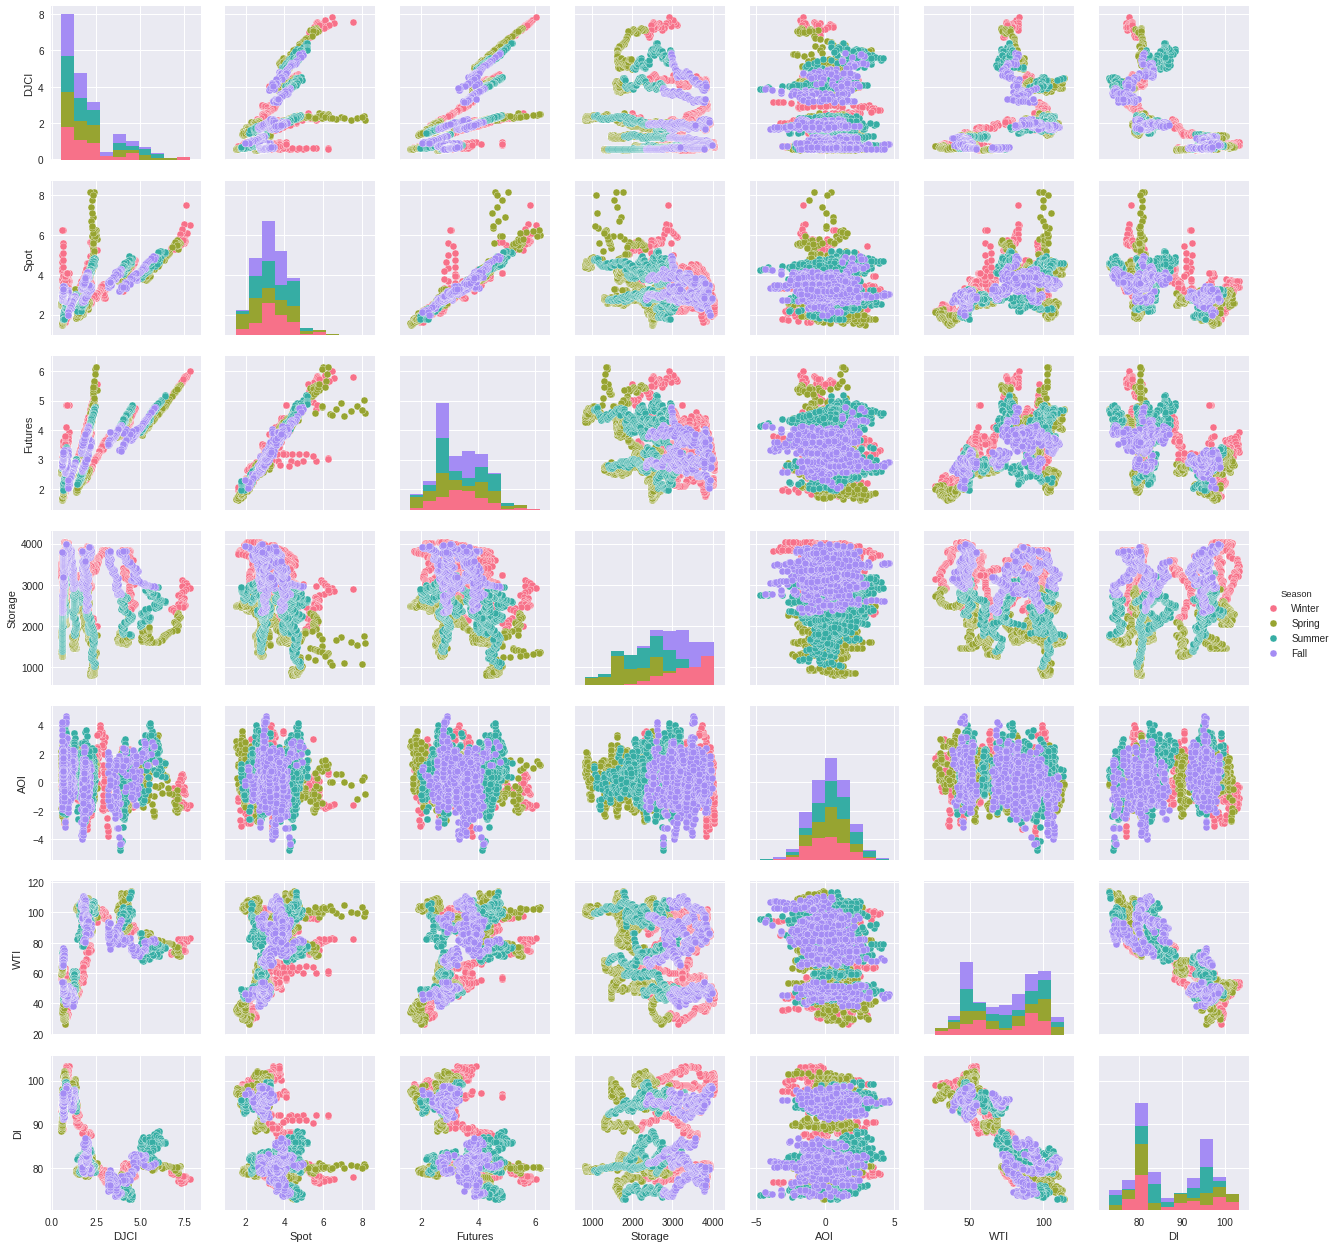

In [0]:
m2season = {  2 : 'Spring' , 5 : 'Summer' ,  8 : 'Fall' , 11 : 'Winter' ,
              3 : 'Spring' , 6 : 'Summer' ,  9 : 'Fall' , 12 : 'Winter' ,
              4 : 'Spring' , 7 : 'Summer' , 10 : 'Fall' ,  1 : 'Winter' }

tmp = M.dropna()
tmp['Season'] = tmp.index.map(lambda x : m2season[x.month])

sns.pairplot(tmp, hue='Season', palette='husl')


In [0]:
M.corr()

,DJCI,Spot,Futures,Storage,AOI,WTI,DI
DJCI,1.000000,0.619127,0.683028,-0.125029,-0.024689,-0.026549,-0.425259
Spot,0.619127,1.000000,0.988293,-0.276821,-0.124472,0.348084,-0.344845
Futures,0.683028,0.988293,1.000000,-0.235506,-0.099970,0.434244,-0.285801
Storage,-0.125029,-0.276821,-0.235506,1.000000,-0.048497,-0.200060,0.108233
AOI,-0.024689,-0.124472,-0.099970,-0.048497,1.000000,0.024698,0.024718
WTI,-0.026549,0.348084,0.434244,-0.200060,0.024698,1.000000,-0.614535
DI,-0.425259,-0.344845,-0.285801,0.108233,0.024718,-0.614535,1.000000


## 데이터 정규화

In [0]:
N = M.dropna().apply(scale, axis = 0)

In [0]:
N.describe()

,DJCI,Spot,Futures,Storage,AOI,WTI,DI
count,3.241000e+03,3.241000e+03,3.241000e+03,3.241000e+03,3.241000e+03,3.241000e+03,3.241000e+03
mean,-2.104662e-16,-2.806216e-16,1.403108e-16,-3.902395e-16,-8.769426e-18,2.104662e-16,-7.015541e-17
std,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00
min,-9.783327e-01,-2.169426e+00,-2.154416e+00,-2.527150e+00,-3.800189e+00,-2.158824e+00,-1.735608e+00
25%,-8.222249e-01,-6.772687e-01,-7.488032e-01,-7.040380e-01,-6.793562e-01,-1.020048e+00,-8.551190e-01
50%,-1.764090e-01,-1.951872e-01,-1.702395e-01,7.740295e-02,1.775514e-02,1.410652e-01,-4.221914e-01
75%,1.828528e-01,6.848028e-01,7.371658e-01,7.923343e-01,6.720020e-01,9.206506e-01,9.729329e-01
max,3.730563e+00,5.475009e+00,3.421058e+00,1.699675e+00,3.240861e+00,1.760101e+00,1.968057e+00


## Facebook Prophet 시계열 분석

In [0]:
M.reset_index(inplace = True)
M.rename(columns={'index':'ds'}, inplace=True)
M.rename(columns={'DJCI' :'y' }, inplace=True)

M = M.dropna()

M.head(5)

,ds,y,Spot,Futures,Storage,AOI,WTI,DI
11323,2010-01-01,7.38,5.8875,5.6475,3117.000000,-1.391,79.8975,77.7775
11324,2010-01-02,7.48,5.9550,5.7250,3078.857143,-1.646,80.4350,77.6950
11325,2010-01-03,7.58,6.0225,5.8025,3040.714286,-1.722,80.9725,77.6125
11326,2010-01-04,7.68,6.0900,5.8800,3002.571429,-1.791,81.5100,77.5300
11327,2010-01-05,7.36,6.1900,5.6400,2964.428571,-1.711,81.7700,77.6200


In [0]:
fb = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5, yearly_seasonality=20)
fb.fit(M)

In [0]:
future = fb.make_future_dataframe(periods=365)
future.tail()

,ds
3601,2019-11-15
3602,2019-11-16
3603,2019-11-17
3604,2019-11-18
3605,2019-11-19


In [0]:
forecast = fb.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3601,2019-11-15,0.505990,-2.983918,3.883854
3602,2019-11-16,0.510039,-2.918312,3.950868
3603,2019-11-17,0.516714,-3.034067,3.905079
3604,2019-11-18,0.523108,-2.945645,3.866755
3605,2019-11-19,0.531426,-2.990098,3.987653


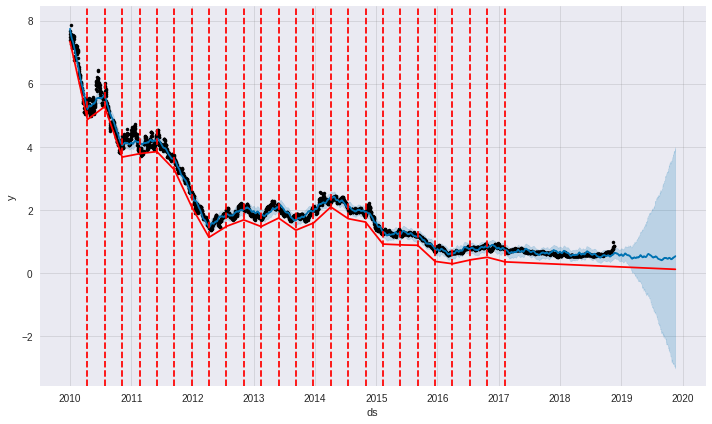

In [0]:
fig1 = fb.plot(forecast)
_ = add_changepoints_to_plot(fig1.gca(), fb, forecast)


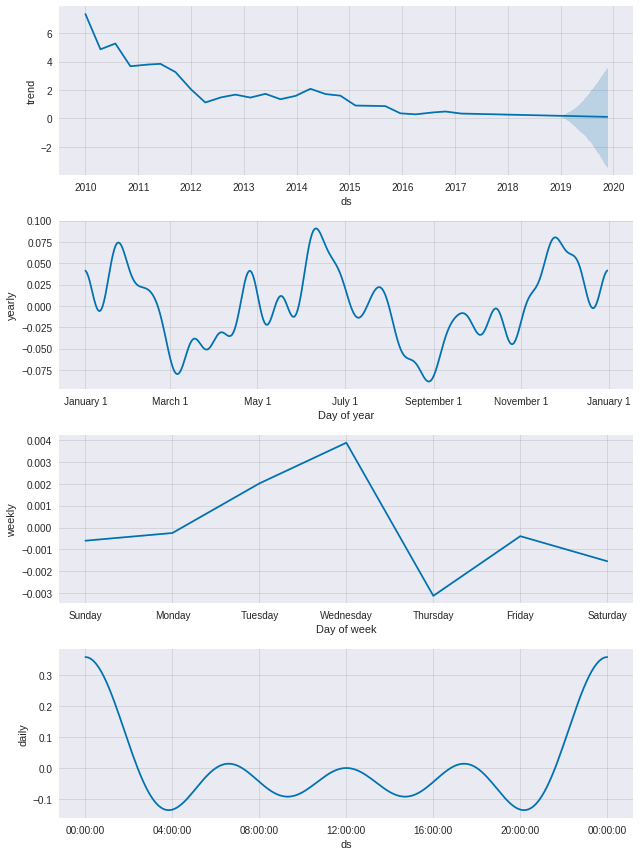

In [0]:
_ = fb.plot_components(forecast)

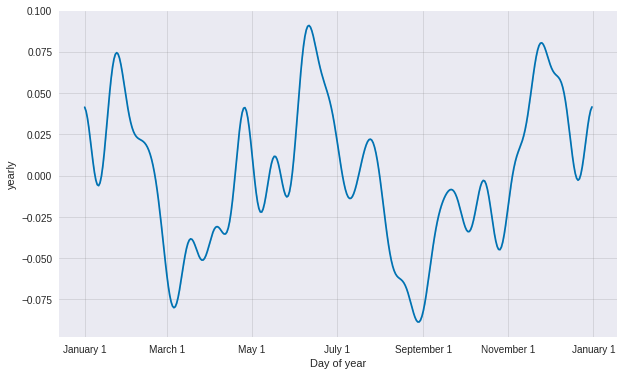

In [0]:
_ = plot_yearly(fb)

In [0]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-380:-330]

,ds,yhat,yhat_lower,yhat_upper
3226,2018-11-01,0.537423,0.365492,0.695546
3227,2018-11-02,0.546351,0.388865,0.721375
3228,2018-11-05,0.562228,0.389298,0.733399
3229,2018-11-06,0.568253,0.401457,0.724384
3230,2018-11-07,0.573134,0.416105,0.735078
3231,2018-11-08,0.568577,0.387135,0.735724
3232,2018-11-09,0.573368,0.413267,0.732605
3233,2018-11-11,0.577275,0.418229,0.731742
3234,2018-11-12,0.580197,0.417354,0.733123
3235,2018-11-13,0.585654,0.419446,0.742003
